In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5',
                               '--exp-name', 'baseline_Melania_Erythroid_human',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Early Erythroid", "Mid  Erythroid"), ('Mid  Erythroid', "Late Erythroid")]
k_cluster = "type2"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt", norm_lr=False):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
        
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, 
                             xyids=[0, 1],
                             device=device,
                             norm_lr=norm_lr
                             )
        
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_human/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')

print(adata)

AnnData object with n_obs × n_vars = 35877 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'leiden', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params', 'type2_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'stc_velocity', 'unspliced', 'variance_stc_velocity'
    obsp: 'connectivities', 'distances'


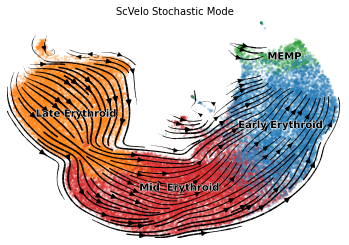

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.081447646, ('Mid  Erythroid', 'Late Erythroid'): 0.04631139}
Total Mean: 0.06387951970100403
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7524644, ('Mid  Erythroid', 'Late Erythroid'): 0.8911031}
Total Mean: 0.8217837810516357
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.3915759926120027, ('Mid  Erythroid', 'Late Erythroid'): -0.659077433493216}
Total Mean: -0.5253267130526094
# In-cluster Coherence
{'Early Erythroid': 0.84404796, 'Late Erythroid': 0.93301064, 'MEMP': 0.94228786, 'Mid  Erythroid': 0.85356015}
Total Mean: 0.893226683139801
# In-cluster Confidence
{'Early Erythroid': 0.8211951176751143, 'Late Erythroid': 0.9371989427152257, 'MEMP': 0.9497227164934267, 'Mid  Erythroid': 0.8122398725342098}
Total Mean: 0.8800891623544941


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 5739.595703
Train Epoch: 200/20000 	Loss: 5737.635742
Train Epoch: 300/20000 	Loss: 5735.922852
Train Epoch: 400/20000 	Loss: 5733.912109
Train Epoch: 500/20000 	Loss: 5731.693848
Train Epoch: 600/20000 	Loss: 5729.400391
Train Epoch: 700/20000 	Loss: 5727.071289
Train Epoch: 800/20000 	Loss: 5724.802734
Train Epoch: 900/20000 	Loss: 5721.955566
Train Epoch: 1000/20000 	Loss: 5719.152344
Train Epoch: 1100/20000 	Loss: 5716.211914
Train Epoch: 1200/20000 	Loss: 5713.021484
Train Epoch: 1300/20000 	Loss: 5709.617676
Train Epoch: 1400/20000 	Loss: 5706.158691
Train Epoch: 1500/20000 	Loss: 5702.535645
Train Epoch: 1600/20000 	Loss: 5698.770996
Train Epoch: 1700/20000 	Loss: 5694.889160
Train Epoch: 1800/20000 	Loss: 5690.866699
Train Epoch: 1900/20000 	Loss: 5686.777344
Train Epoch: 2000/20000 	Loss: 5682.612793
Train Epoch: 2100/20000 	Loss: 5678.292480
Train Epoch: 2200/20000 	Loss: 5673.917480
Train Epoch: 2300/20000 	Loss: 5669.473145
Train Epoch: 2400/20

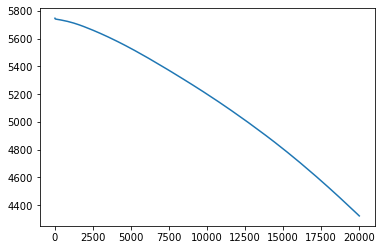

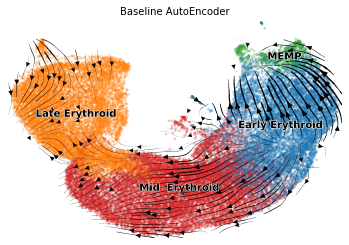

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.19470708, ('Mid  Erythroid', 'Late Erythroid'): 0.027665582}
Total Mean: 0.11118633300065994
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9652596, ('Mid  Erythroid', 'Late Erythroid'): 0.9775132}
Total Mean: 0.9713864326477051
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.15082660445308407, ('Mid  Erythroid', 'Late Erythroid'): -0.1554547775384933}
Total Mean: -0.0023140865427046103
# In-cluster Coherence
{'Early Erythroid': 0.9867095, 'Late Erythroid': 0.9865447, 'MEMP': 0.9966625, 'Mid  Erythroid': 0.98179114}
Total Mean: 0.9879269599914551
# In-cluster Confidence
{'Early Erythroid': 0.9847168551121751, 'Late Erythroid': 0.9858384066388829, 'MEMP': 0.9922962704544547, 'Mid 

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    args.lr = 1e-4
    model = get_baseline_AE(in_dim, z_dim, h_dim, True).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}", norm_lr=True)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, norm=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 5686.987305
Train Epoch: 200/20000 	Loss: 5541.192871
Train Epoch: 300/20000 	Loss: 5170.457520
Train Epoch: 400/20000 	Loss: 4285.197754
Train Epoch: 500/20000 	Loss: 2576.590820
Train Epoch: 600/20000 	Loss: 827.742737
Train Epoch: 700/20000 	Loss: 234.805115
Train Epoch: 800/20000 	Loss: 151.018433
Train Epoch: 900/20000 	Loss: 137.945877
Train Epoch: 1000/20000 	Loss: 134.331879
Train Epoch: 1100/20000 	Loss: 132.179779
Train Epoch: 1200/20000 	Loss: 130.120132
Train Epoch: 1300/20000 	Loss: 127.815506
Train Epoch: 1400/20000 	Loss: 125.063362
Train Epoch: 1500/20000 	Loss: 121.701401
Train Epoch: 1600/20000 	Loss: 117.539345
Train Epoch: 1700/20000 	Loss: 112.359734
Train Epoch: 1

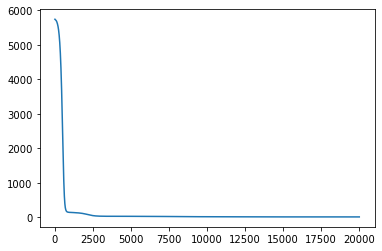

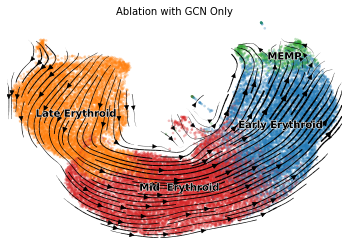

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.021332923, ('Mid  Erythroid', 'Late Erythroid'): 0.046496082}
Total Mean: 0.03391450271010399
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9999576, ('Mid  Erythroid', 'Late Erythroid'): 0.99987054}
Total Mean: 0.9999140501022339
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.5160739074656994, ('Mid  Erythroid', 'Late Erythroid'): -0.3761041934437737}
Total Mean: -0.44608905045473657
# In-cluster Coherence
{'Early Erythroid': 0.99998444, 'Late Erythroid': 0.9999003, 'MEMP': 0.9999957, 'Mid  Erythroid': 0.99994874}
Total Mean: 0.999957263469696
# In-cluster Confidence
{'Early Erythroid': 0.9999806454789134, 'Late Erythroid': 0.9998995635908587, 'MEMP': 0.9999912795030845, 'Mid 

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    args.lr = 1e-5
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 5727.777344
Train Epoch: 200/20000 	Loss: 5722.494629
Train Epoch: 300/20000 	Loss: 5719.036621
Train Epoch: 400/20000 	Loss: 5716.617188
Train Epoch: 500/20000 	Loss: 5715.536621
Train Epoch: 600/20000 	Loss: 5714.833496
Train Epoch: 700/20000 	Loss: 5714.230957
Train Epoch: 800/20000 	Loss: 5713.616699
Train Epoch: 900/20000 	Loss: 5713.083984
Train Epoch: 1000/20000 	Loss: 5712.551270
Train Epoch: 1100/20000 	Loss: 5712.084961
Train Epoch: 1200/20000 	Loss: 5711.605957
Train Epoch: 1300/20000 	Loss: 5711.233887
Train Epoch: 1400/20000 	Loss: 5710.636719
Train Epoch: 1500/20000 	Loss: 5710.206543
Train Epoch: 1600/20000 	Loss: 5709.696777
Train Epoch: 1700/20000 	Loss: 5709.203613
Train Epoch: 1800/20000 	Loss: 5708.728027
Train Epoch: 1900/20000 	Loss: 5708.254883
Train Epoch: 2000/20000 	Loss: 5707.825195
Train Epoch: 2100/20000 	Loss: 5707.304688
Train Epoch: 2200/20000 	Loss: 5706.914062
Train Epoch: 2300/20000 	Loss: 5706.473633
Train Epoch: 2400/20

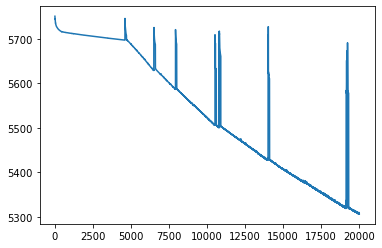

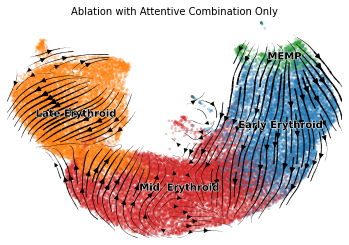

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.11343605, ('Mid  Erythroid', 'Late Erythroid'): 0.1509277}
Total Mean: 0.13218186795711517
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9977254, ('Mid  Erythroid', 'Late Erythroid'): 0.99605435}
Total Mean: 0.9968898892402649
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.21840891748449126, ('Mid  Erythroid', 'Late Erythroid'): 0.38219374521336014}
Total Mean: 0.30030133134892567
# In-cluster Coherence
{'Early Erythroid': 0.9981054, 'Late Erythroid': 0.98911816, 'MEMP': 0.9970749, 'Mid  Erythroid': 0.99873006}
Total Mean: 0.9957571029663086
# In-cluster Confidence
{'Early Erythroid': 0.9978876835022028, 'Late Erythroid': 0.9890858542482647, 'MEMP': 0.9945327537614594, 'Mid  Er

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    args.lr = 1e-4
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device,
        True
    )
    
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}", norm_lr=True)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, norm=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:11) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:10) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


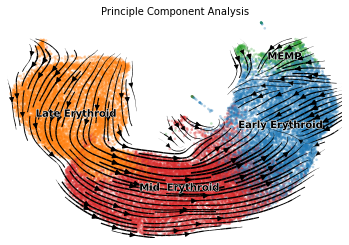

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.12044878, ('Mid  Erythroid', 'Late Erythroid'): 0.26103657}
Total Mean: 0.19074267148971558
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.74440134, ('Mid  Erythroid', 'Late Erythroid'): 0.94988316}
Total Mean: 0.847142219543457
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.25416566230376175, ('Mid  Erythroid', 'Late Erythroid'): -0.41750785023953735}
Total Mean: -0.33583675627164955
# In-cluster Coherence
{'Early Erythroid': 0.7268836, 'Late Erythroid': 0.98635113, 'MEMP': 0.7473096, 'Mid  Erythroid': 0.90000296}
Total Mean: 0.8401368260383606
# In-cluster Confidence
{'Early Erythroid': 0.7169492476173499, 'Late Erythroid': 0.9849106729030609, 'MEMP': 0.6474130238236496, 'Mid

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy(),
                                   norm_lr=True
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:09) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:09) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


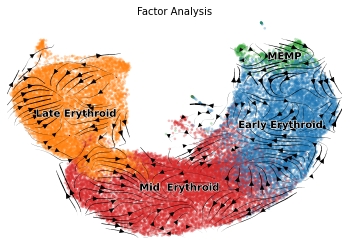

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.051190756, ('Mid  Erythroid', 'Late Erythroid'): 0.048342533}
Total Mean: 0.04976664483547211
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.22241148811428105, ('Mid  Erythroid', 'Late Erythroid'): 0.21501367023389925}
Total Mean: 0.21871257917409015
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.14356650881824146, ('Mid  Erythroid', 'Late Erythroid'): 0.05678449879789864}
Total Mean: 0.10017550380807005
# In-cluster Coherence
{'Early Erythroid': 0.2936741744484105, 'Late Erythroid': 0.2730160146545372, 'MEMP': 0.4316049502239248, 'Mid  Erythroid': 0.3232671480024095}
Total Mean: 0.33039057183232046
# In-cluster Confidence
{'Early Erythroid': 0.2770174405843543, 'Late Erythroid'

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy(),
                                   norm_lr=True
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)